# Quadratic Hamiltonians and Slater determinants

A quadratic Hamiltonian is a Hamiltonian of the form
$$
    H =
    \sum_{j, k} M_{jk} a^\dagger_j a_k
    + \frac12 \sum_{j, k}
        (\Delta_{jk} a^\dagger_j a^\dagger_k + \Delta^*_{jk} a_k a_j)
    + \text{constant}
$$
where $M$ is a Hermitian matrix ($M^\dagger = M$) and $\Delta$ is an antisymmetric matrix ($\Delta^T = -\Delta$), and the $\{a_j^\dagger\}$ are fermionic creation operators which satisfy the anticommutation relations
$$
    \begin{align}
        a_j a_k + a_k a_j &= 0 \\
        a_j a^\dagger_k + a^\dagger_k a_j &= \delta_{pq}
    \end{align}.
$$

Quadratic Hamiltonians are an important class of Hamiltonians that are classically tractable. Their eigenstates are called fermionic Gaussian states, and they can be efficiently prepared on a quantum computer. Qiskit Nature includes the `QuadraticHamiltonian` class for representing quadratic Hamiltonians.

Of course, the `FermionicOp` class can also be used to represent any quadratic Hamiltonian. The reason to have a class specifically for quadratic Hamiltonians is that they support special numerical routines that involve performing linear algebra on the matrices $M$ and $\Delta$. The internal representation format of `FermionicOp` is not suitable for these routines.

A quadratic Hamiltonian is initialized like so:

In [1]:
import numpy as np
from qiskit_nature.second_quantization.operator_factories import QuadraticHamiltonian

# create Hamiltonian
hermitian_part = np.array(
    [
        [1.0, 2.0, 0.0, 0.0],
        [2.0, 1.0, 2.0, 0.0],
        [0.0, 2.0, 1.0, 2.0],
        [0.0, 0.0, 2.0, 1.0],
    ]
)
antisymmetric_part = np.array(
    [
        [0.0, 3.0, 0.0, 0.0],
        [-3.0, 0.0, 3.0, 0.0],
        [0.0, -3.0, 0.0, 3.0],
        [0.0, 0.0, -3.0, 0.0],
    ]
)
constant = 4.0

hamiltonian = QuadraticHamiltonian(
    hermitian_part=hermitian_part,
    antisymmetric_part=antisymmetric_part,
    constant=constant,
)

# convert it to a FermionicOp and print it
hamiltonian_ferm = hamiltonian.to_fermionic_op()
hamiltonian_ferm.set_truncation(0)
print(hamiltonian_ferm)

Fermionic Operator
register length=4, number terms=29
  4.0
+ 1.0 * ( +_0 -_0 )
+ 2.0 * ( +_0 -_1 )
+ 2.0 * ( +_1 -_0 )
+ 3.0 * ( +_0 +_1 )
+ 3.0 * ( -_1 -_0 )
+ 0.0 * ( +_0 -_2 )
+ 0.0 * ( +_2 -_0 )
+ 0.0 * ( +_0 +_2 )
+ 0.0 * ( -_2 -_0 )
+ 0.0 * ( +_0 -_3 )
+ 0.0 * ( +_3 -_0 )
+ 0.0 * ( +_0 +_3 )
+ 0.0 * ( -_3 -_0 )
+ 1.0 * ( +_1 -_1 )
+ 2.0 * ( +_1 -_2 )
+ 2.0 * ( +_2 -_1 )
+ 3.0 * ( +_1 +_2 )
+ 3.0 * ( -_2 -_1 )
+ 0.0 * ( +_1 -_3 )
+ 0.0 * ( +_3 -_1 )
+ 0.0 * ( +_1 +_3 )
+ 0.0 * ( -_3 -_1 )
+ 1.0 * ( +_2 -_2 )
+ 2.0 * ( +_2 -_3 )
+ 2.0 * ( +_3 -_2 )
+ 3.0 * ( +_2 +_3 )
+ 3.0 * ( -_3 -_2 )
+ 1.0 * ( +_3 -_3 )


## Diagonalization and state preparation
A quadratic Hamiltonian can always be rewritten in the form
$$
    H = \sum_{j} \varepsilon_j b^\dagger_j b_j + \text{constant}
$$
where $\varepsilon_0 \leq \varepsilon_1 \leq \cdots \leq \varepsilon_N$ are non-negative real numbers called orbitals energies and
the $\{b_j^\dagger\}$ are a new set of fermionic creation operators
that also satisfy the canonical anticommutation relations.
These new creation operators are linear combinations of the original creation and annihilation operators:
$$
    \begin{pmatrix}
    b^\dagger_1 \\
    \vdots \\
    b^\dagger_N \\
    \end{pmatrix}
    = W
    \begin{pmatrix}
    a^\dagger_1 \\
    \vdots \\
    a^\dagger_N \\
    a_1 \\
    \vdots \\
    a_N
    \end{pmatrix},
$$
where $W$ is an $N \times 2N$ matrix. Given a basis of eigenvectors of the Hamiltonian, each eigenvector is labeled by a subset of $\{0, \ldots, N - 1\}$, which we call the occupied orbitals. The corresponding eigenvalue is the sum of the corresponding values of $\varepsilon_j$, plus the constant.

In [2]:
# get the transformation matrix W and orbital energies {epsilon_j}
(
    transformation_matrix,
    orbital_energies,
    transformed_constant,
) = hamiltonian.diagonalizing_bogoliubov_transform()

print(f"Shape of matrix W: {transformation_matrix.shape}")
print(f"Orbital energies: {orbital_energies}")
print(f"Transformed constant: {transformed_constant}")

Shape of matrix W: (4, 8)
Orbital energies: [0.29826763 4.38883678 5.5513683  5.64193745]
Transformed constant: -1.9402050758492795


The transformation matrix $W$ is used to construct a circuit to prepare an eigenvector of the Hamiltonian. The circuit is constructed using the `FermionicGaussianState` class. Currently, only the [Jordan-Wigner Transform](https://qiskit.org/documentation/nature/stubs/qiskit_nature.mappers.second_quantization.JordanWignerMapper.html)
is supported. The circuit for the Jordan-Wigner Transform has linear depth and uses only linear qubit connectivity. The algorithm is from [Phys. Rev. Applied 9, 044036](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.9.044036).

Eigenvalue: 3.909430851761581


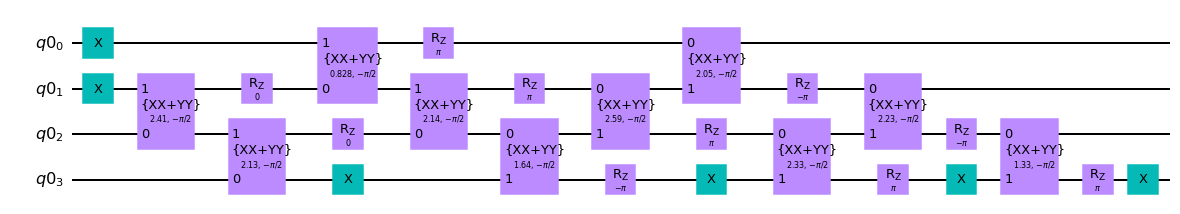

In [3]:
from qiskit_nature.circuit.library import FermionicGaussianState

occupied_orbitals = (0, 2)
eig = np.sum(orbital_energies[list(occupied_orbitals)]) + transformed_constant
print(f"Eigenvalue: {eig}")

circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals=occupied_orbitals)
circuit.draw("mpl")

The following code cell simulates the circuit and verifies that the output state is indeed an eigenstate of the Hamiltonian with the expected eigenvalue.

In [4]:
from qiskit.quantum_info import Statevector
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

# simulate the circuit to get the final state
state = np.array(Statevector(circuit))

# convert the Hamiltonian to a matrix
hamiltonian_jw = JordanWignerMapper().map(hamiltonian_ferm).to_matrix()

# check that the state is an eigenvector with the expected eigenvalue
np.testing.assert_allclose(hamiltonian_jw @ state, eig * state, atol=1e-8)

## Slater determinants

When the antisymmetric part $\Delta = 0$, then the Hamiltonian conserves the number of particles. In this case, the basis change only needs to mix creation operators, not annihilation operators:
$$
    \begin{pmatrix}
    b^\dagger_1 \\
    \vdots \\
    b^\dagger_N \\
    \end{pmatrix}
    = W
    \begin{pmatrix}
    a^\dagger_1 \\
    \vdots \\
    a^\dagger_N \\
    \end{pmatrix},
$$
where now $W$ is an $N \times N$ matrix. Furthermore, the orbital energies $\{\varepsilon_j\}$ are allowed to be negative.

In [5]:
# create Hamiltonian
hermitian_part = np.array(
    [
        [1.0, 2.0, 0.0, 0.0],
        [2.0, 1.0, 2.0, 0.0],
        [0.0, 2.0, 1.0, 2.0],
        [0.0, 0.0, 2.0, 1.0],
    ]
)
constant = 4.0

hamiltonian = QuadraticHamiltonian(
    hermitian_part=hermitian_part,
    constant=constant,
)

print(f"Hamiltonian conserves particle number: {hamiltonian.conserves_particle_number()}")

Hamiltonian conserves particle number: True


In [6]:
# get the transformation matrix W and orbital energies {epsilon_j}
(
    transformation_matrix,
    orbital_energies,
    transformed_constant,
) = hamiltonian.diagonalizing_bogoliubov_transform()

print(f"Shape of matrix W: {transformation_matrix.shape}")
print(f"Orbital energies: {orbital_energies}")
print(f"Transformed constant: {transformed_constant}")

Shape of matrix W: (4, 4)
Orbital energies: [-2.23606798 -0.23606798  2.23606798  4.23606798]
Transformed constant: 4.0


In this special case, the eigenstates are called Slater determinants, and a more efficient algorithm is used to prepare them. This algorithm is accessed by using the `SlaterDeterminant` class instead of `FermionicGaussianState`. `SlaterDeterminant` does not take the occupied orbitals as input. Instead, the shape of the transformation matrix is allowed to vary. It should be an $\eta \times N$ matrix where $\eta$ is the number of particles.

Eigenvalue: 4.000000000000001


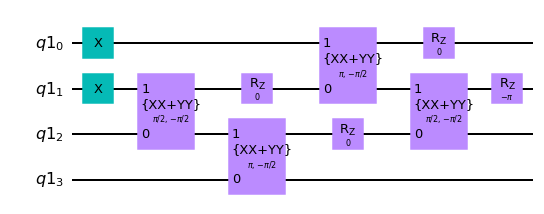

In [7]:
from qiskit_nature.circuit.library import SlaterDeterminant

occupied_orbitals = (0, 2)
eig = np.sum(orbital_energies[list(occupied_orbitals)]) + transformed_constant
print(f"Eigenvalue: {eig}")

circuit = SlaterDeterminant(transformation_matrix[list(occupied_orbitals)])
circuit.draw("mpl")

## Time evolution

Time evolution under a quadratic Hamiltonian can be easily performed by changing into the diagonal basis of the Hamiltonian. The state preparation circuits shown above effect this basis change, but they are optimized for state preparation from a computational basis state (assumed to be the all zeros state), and they do not work on arbitrary states. The general unitary basis change which does work on arbitrary states is called the Bogoliubov transform, and it is also implemented in Qiskit Nature.

The code block below demonstrates the use of the Bogoliubov transform to implement time evolution for a quadratic Hamiltonian.

In [8]:
from qiskit_nature.circuit.library import BogoliubovTransform
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import random_hermitian, random_statevector, state_fidelity
from scipy.linalg import expm

# create Hamiltonian
n_modes = 5
hermitian_part = np.array(random_hermitian(n_modes))
hamiltonian = QuadraticHamiltonian(hermitian_part=hermitian_part)

# diagonalize Hamiltonian
(
    transformation_matrix,
    orbital_energies,
    _,
) = hamiltonian.diagonalizing_bogoliubov_transform()

# set simulation time and construct time evolution circuit
time = 1.0
register = QuantumRegister(n_modes)
circuit = QuantumCircuit(register)
bog_circuit = BogoliubovTransform(transformation_matrix)
# change to the diagonal basis of the Hamiltonian
circuit.append(bog_circuit.inverse(), register)
# perform time evolution by applying z rotations
for q, energy in zip(register, orbital_energies):
    circuit.rz(-energy * time, q)
# change back to the original basis
circuit.append(bog_circuit, register)

# simulate the circuit
initial_state = random_statevector(2**n_modes)
final_state = initial_state.evolve(circuit)

# compute the correct state by direct exponentiation
hamiltonian_jw = JordanWignerMapper().map(hamiltonian.to_fermionic_op()).to_matrix()
exact_evolution_op = expm(-1j * time * hamiltonian_jw)
expected_state = exact_evolution_op @ np.array(initial_state)

# check that the simulated state is correct
fidelity = state_fidelity(final_state, expected_state)
np.testing.assert_allclose(fidelity, 1.0, atol=1e-8)

In [9]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright